In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy #Not technically necessary, but prevents dictionary linking
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 10})
#matplotlib.font_manager._rebuild() #Must include after font change due to creation of stupid files by conda/spyder
from scipy import special
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#Figure width and height to match LaTeX document width
width = 5.97 #textwidth in inches (430 pt)
#height = 3.25

In [2]:
def r_to_dB(r):
    """
    Convert squeezing to dB units

    Parameters
    ----------
    r: float
        Squeezing value

    Returns
    -------
    float
        -10*np.log10(np.exp(-2*r))

    """
    return -10*np.log10(np.exp(-2*r))

def dB_to_r(dB):
    """
    Convert from dB squeezing to squeezing value

    Parameters
    ----------
    dB: float
        Squeezing in dB

    Returns
    -------
    float
        -np.log(10**(-dB/10))/2
    """
    return -np.log(10**(-dB/10))/2

In [58]:
class simulation():
    """
    
    Simulation of a 3-mode tritter correction scheme correcting 
    an arbitrary x-displacement error
    
    ...
    
    Attributes
    ----------
    
    r: float
        Ancilla squeezing parameter (NOT in dB units)
        
    errorsize: float
        Size of the error-induced displacement in the x-quadrature
        
    perror: float
        Probability of the error occuring in each mode
        
    xcutoff: float
        Cutoff value for binning the ancilla during read-off for syndrome recognition.
    
    N: int, optional
        Number of points for plotting the Wigner function in x (default N = 1000)
        
    dec_dict: dict
        Dictionary over the 3 decoded x-quadrature components for all possible error types 
        and their syndrome patterns
        
    syndromes_dict: dict
        Dictionary over the error recovery operations based on the binned ancilla syndrome patterns. 
    
    new_dict: dict
        Updated dictionary with probabilities pi and pj from dict_pipj() method
        
        
    Methods
    -------
    
    get_pi_coeff()    
        Returns a numpy array (size 8) over the probabilities of an error occuring in one, two or all three modes. 
    
    get_bounds_dict()
        Returns a dictionary over the probability of measuring the ancilla in the -, + or 0 data bin.
        
    dict_pipj()
        Returns an updated dictionary of the probabilities pi for each of the eight error vectors
        and pj for the nine ways to bin the ancilla measurements
    
    fidelity_pure()
        Calculate the fidelity between two Gaussian states where at least one is pure
    
    get_fidelity()
        Calculate the fidelity between the corrected state Wavg and Win (zero displacement coherent state)
        
    get_fidelity_raw()
        Calculate the fidelity between the uncorrected state and Win
        
    Wig()
        Evaluate the Wavg for plotting
        
    Wig_coherent()
        Evaluate Win for plotting
    
    get_Wigner()
        Get array of Wavg evaluated in X array for plotting
    
    
    """
    
    
    def __init__(self,r,dx,p,xc,N=1000):
        """
        
        Parameters
        ----------
        
        r: float
            Ancilla squeezing parameter (NOT in dB units)
        
        dx: float
            Size of the error-induced displacement in the x-quadrature
        
        p: float
            Probability of the error occuring in each mode
        
        xc: float
            Cutoff value for binning the ancilla during read-off for syndrome recognition.
          
        N: int, optional
            Number of points (density) for plotting the Wigner function in x (default N = 1000)
        
        """
        self.r = r
        self.errorsize = dx
        self.perror = p
        self.xcutoff = xc
        self.N = N 
        
        dec_dict = {'(0,0,0)':
       {'xdec': np.array([0,0,0]),'pattern':'00'},  
       
       '(dx,0,0)':
       {'xdec': np.array([1/np.sqrt(3),-1/np.sqrt(6),-1/np.sqrt(2)]),'pattern':'--'},
       
       '(0,dx,0)':
       {'xdec': np.array([1/np.sqrt(3),np.sqrt(2/3),0]),'pattern':'+0'},
       
       '(0,0,dx)':
       {'xdec': np.array([1/np.sqrt(3),-1/np.sqrt(6),1/np.sqrt(2)]),'pattern':'-+'},
       
       '(dx,dx,0)':
       {'xdec': np.array([2/np.sqrt(3),1/np.sqrt(6),-1/np.sqrt(2)]),'pattern':'+-'},
       
       '(dx,0,dx)':
       {'xdec': np.array([2/np.sqrt(3),-np.sqrt(2/3),0]),'pattern':'-0'},
       
       '(0,dx,dx)':
       {'xdec': np.array([2/np.sqrt(3),1/np.sqrt(6),1/np.sqrt(2)]),'pattern':'++'},
       
       '(dx,dx,dx)':
       {'xdec': np.array([np.sqrt(3),0,0]),'pattern':'00'}}
    
    
    
        self.dec_dict = dec_dict
        
        syndrome_dict = {'00':{'s': np.array([0,0])},
                     
        '--': {'s': np.array([1/np.sqrt(2),1/np.sqrt(6)])},
                     
        '+0': {'s': np.array([-1/np.sqrt(2),1])},
                     
        '-+': {'s': np.array([1/np.sqrt(2),-1/np.sqrt(6)])},
                     
        '+-': {'s': np.array([1/np.sqrt(2),-1/np.sqrt(6)])},
                     
        '-0': {'s': np.array([-1/np.sqrt(2),1])},
                     
        '++': {'s': np.array([1/np.sqrt(2),1/np.sqrt(6)])},
                    
        '0+': {'s': np.array([0,0])},
        
        '0-': {'s': np.array([0,0])}}
        
        self.syndrome_dict = syndrome_dict
        
        new_dict = self.dict_pipj()
        self.new_dict = new_dict
        
        
    
    #First, define dictionaries for decoded displacement vectors and feedforward protocols based on syndrome
    
    
    
    
        
    def get_pi_coeff(self):
        """
        Get the eight possible error outcome probabilities
        
        Returns
        -------
        pi: numpy.ndarray 
            Array (size 8) of the combinations of stochastic error probabilities 
        
        """
        
        p = self.perror
        pi = np.concatenate((np.array([(1-p)**3]),np.repeat((1-p)**2*p,3),np.repeat((1-p)*p**2,3),np.array([p**3])))
        return pi
    
    
    def get_bounds_dict(self,xdec):
        
        """
        Parameters
        ----------
        
        xdec: float
            Decoded x-component of the ancilla
            
        Returns
        -------
        
        bounds_dict: dict
            Dictionary over the probability to measure the ancilla in the -, + or 0 bin.
            
        """
        r = self.r
        xc = self.xcutoff
        bounds_dict = {'-': {'P': 1/2*(1-special.erf(np.exp(r)*(xc+xdec)))},
                  '+': {'P': 1/2*(1-special.erf(np.exp(r)*(xc-xdec)))},
                  '0': {'P': 1/2*(special.erf(np.exp(r)*(xc-xdec))+special.erf(np.exp(r)*(xc+xdec)))}}
        return bounds_dict
    
    ##Add pi and pj to dic
    
    def dict_pipj(self):
        
        """
        Returns
        -------
        
        new: dict
            Dictionary containing the probabilities pi for each of the eight error vectors
            and pj for the nine ways to bin the ancilla measurements
            
        NOTE: this unfortunately changes the dec_dict attribute, despite copying
        SOLVED: by using copy.deepcopy()
        """
        #Get pi
        pi = self.get_pi_coeff()
        
        #new = dic.copy()
        new = copy.deepcopy(self.dec_dict)
        #new = {}
        #new.update(self.dec_dict.copy())
        #new = self.dec_dict.copy()
        
        for i,key in enumerate(new):

            new[key]['pi'] = pi[i]
            
            #Get the decoded x-quadrature component
            xdec = new[key]['xdec']*self.errorsize
        
            #Get the bin probabilities for each ancilla
            bound1 = self.get_bounds_dict(xdec[1])
            bound2 = self.get_bounds_dict(xdec[2])
            
            #Get pj            
            pat = ['00','--','+0','-+','+-','-0','++','0+','0-']
            pj = np.zeros(9)
            for i, p in enumerate(pat):

                P1 = bound1[p[0]]['P']
                P2 = bound2[p[1]]['P']
                pj[i] = P1*P2
    
            new[key]['pj'] = pj
        return new
    
    def get_pjmax(self):
        dic = self.dict_pipj()
        dec = self.dec_dict
        pjmax = np.zeros(8)
        i = 0
        for key in dic.keys():
            pj = dic[key]['pj']
            pat = dec[key]['pattern']
            idx = [i for i, test in enumerate(pjkey) if test == pat][0]
            pjmax[i] = pj[idx]
            i += 1
            
        return pjmax
    
    def fidelity_pure(self,sigma1,sigma2,r1,r2):
        """
        Calculate the fidelity between W1(sigma1,r1) and W2(sigma2,r2) (Gaussians)
        where at least one state is pure
        
        NOTE: The fidelity is defined in the squared form to compare to a probability
        
        Parameters
        ----------
        sigma1, sigma2: numpy.ndarray
            Covariance matrix (2x2)

        r1, r2: numpy.ndarray
            Displcement vector (2x1)
    
        Returns
        -------
        f: float
            The calculated fidelity
        
        """
        S = sigma1+sigma2
        dr = r2-r1
        #f = 1/(np.linalg.det(S)**(1/4))*np.exp(-1/4*np.transpose(dr).dot(np.linalg.inv(S).dot(dr)))
        
        #Must use square to relate to probability
        f = 1/np.sqrt(np.linalg.det(S))*np.exp(-1/2*np.transpose(dr).dot(np.linalg.inv(S).dot(dr)))
        return f
    
    def get_fidelity(self):
        """
        Calculate the fidelity between Wff and Win (zero displacement coherent state)
        
        Returns
        -------
        Fij: numpy.ndarray
            (8x9) matrix of fidelities. Use np.sum(Fij) to get total fidelity
        
        """ 
        
        Fij = np.zeros((8,9))
        dic = self.new_dict
        dx = self.errorsize
        r = self.r
        
        #Zero data mode for simplicity
        xbar = 0
        pbar = 0
        
        #Input state
        sigma1 = 1/2*np.identity(2)
        r1 = np.array([xbar,pbar])
        
        #Get ij state
        for i, key in enumerate(dic):
            xdec = dic[key]['xdec']*dx
            pi = dic[key]['pi']
            pj = dic[key]['pj']
            for j, pat in enumerate(self.syndrome_dict):
                s = self.syndrome_dict[pat]['s']
                s2 = s[0]
                s3 = s[1]
                
                sigma2 = 1/2*np.array([[1+s2**2*np.exp(-2*r)+s3**2*np.exp(-2*r),0],[0,1]])
                r2 = np.array([xbar+xdec[0]+s2*xdec[1]+s3*xdec[2],pbar])
                
                #Compute fidelity
                Fij[i,j] = pi*pj[j]*self.fidelity_pure(sigma1,sigma2,r1,r2)
                
        return Fij
        
    
    def get_fidelity_raw(self):
        
        """
        Get fidelity between uncorrected state and Win
        
        Returns
        -------
        
        f: float
            Computed fidelity
        """
                
        p = self.perror
        dx = self.errorsize
        
        #Input state
        sigma1 = 1/2*np.identity(2)
        r1 = np.array([0,0])
        
        #Uncorrected state is a statistical mixture
        sigma2 = 1/2*np.identity(2)
        
        f = (1-p)*self.fidelity_pure(sigma1,sigma2,r1,np.array([0,0]))+p*self.fidelity_pure(sigma1,sigma2,r1,np.array([dx,0]))
        return f
        
    
    
    def Wig(self,x,xbar):
        """
        Get average Wigner function after feedforwarding (Wavg)
        
        Parameters
        ----------
        
        x: float
            x-quadrature value where the Wigner function is evaluated
            
        xbar: float
            x-displacement of data mode (0)
            
        Returns
        -------
        
        Wij: numpy.ndarray
            (8x9) matrix of the ij components of the Wigner function Wavg
            Use np.sum(Wij) to get total Wigner function
        
        """
        Wij = np.zeros((8,9))
        dic = self.new_dict
        dx = self.errorsize
        r = self.r
        
        for i, key in enumerate(dic):
            xdec = dic[key]['xdec']*dx
            pi = dic[key]['pi']
            pj = dic[key]['pj']
            for j, pat in enumerate(self.syndrome_dict):
                s = self.syndrome_dict[pat]['s']
                s2 = s[0]
                s3 = s[1]
                
                prefactor = 1/np.sqrt(np.pi*(1+s2**2*np.exp(-2*r)+s3**2*np.exp(-2*r)))
                #prefactor = 1/np.sqrt(np.pi)*np.sqrt(1/(s2**2*np.exp(-2*r)+1))*np.sqrt(1/(s3**2*np.exp(-2*r)+s3**2/s2**2+1))
                exponent = -(np.exp(2*r)*(x-(xbar+xdec[0]+s2*xdec[1]+s3*xdec[2]))**2)/(np.exp(2*r)+s2**2+s3**2)
                Wij[i,j] = pi*pj[j]*prefactor*np.exp(exponent)
                
        return Wij
    
    def P_coherent(self,x,xbar):
        
        """
        Evaluate marginal probability for coherent state
        
        Parameters
        ----------
        x: float, numpy.ndarray
            x-quadrature value where the Wigner function is evaluated
        xbar: float
            x-displacement of data mode (0)
        Returns
        -------
        P: float
            Evaluated marginal probability
        """
        
        P = np.sqrt(1/np.pi)*np.exp(-(x-xbar)**2)
        return P
                
    def plotWigner(self):
        
        """
        Plots the Pavg (marginal distribution in x) for the instance of the Class
        alongside the uncorrected, and original marginal distribution
        
        Returns
        -------
        None, makes plot
        
        """
        p = self.perror
        dx = self.errorsize
        xc = self.xcutoff
        r = self.r
        dB = r_to_dB(r)
        N = self.N
        
        X = np.linspace(-5,np.sqrt(3)*dx+3,N)
        xbar = 0
        W = np.zeros(N)
        Wrel = np.zeros(N)
        for i, x in enumerate(X):
            W[i] = np.sum(self.Wig(x,xbar))
            Wrel[i] = p*self.P_coherent(x,xbar+dx)+(1-p)*self.P_coherent(x,xbar)
            
        #Check normalisation
        N = np.sum(W)*(X[1]-X[0]) 
        M = np.sum(Wrel)*(X[1]-X[0])
        
        print('Wcor Numerical norm = {} '.format(N))
        print('Worg Numerical norm = {}'.format(M))
        
        plt.plot(X,W)
        plt.plot(X,Wrel)
        plt.plot(X,self.P_coherent(X,xbar))        
        
        plt.xlabel(r'$x$-quadrature')
        plt.ylabel(r'Marginal distribution, $P_{\mathrm{avg}}(x)$')
        plt.title(r'Marginal distribution')
        plt.legend(['After feedforwarding operations'+
                    '\n'+r'$r={:.1f}$ dB, $\delta x = {}$, $p = {}$'.format(dB,dx,p),
                   r'Uncorrected stochastic error',r'Original coherent state'])
        
        plt.show()
        
   
    def get_Wigner(self):
        
        """
        Get Wavg for plotting marginal distribution in x-quadrature
        
        Returns
        -------
        
        W: numpy.ndarray
            Array of Wavg (size: 1000) evaluated in x
            
        X: numpy.ndarray
            Array of x-values where Wavg is evaluated in.
            
        """
        dx = self.errorsize  
        N = self.N
        
        #Manual xlims
        X = np.linspace(-5,np.sqrt(3)*dx+3,N)
        xbar = 0
        W = np.zeros(N)
        for i, x in enumerate(X):
            W[i] = np.sum(self.Wig(x,xbar))
        return W, X
           

#### Advanced functions

In [3]:
def plot_pj(R,dx,p,xc):

    """
    Plot pj's for different values of squeezing and xcutoff

    Parameters
    ----------

    R: numpy.ndarray
        Squeezing array
        
    dx: float
        x-displacement size

    p: float
        Error probability    

    xc: numpy.ndarray
        xcutoff value for binning ancilla results

    Returns
    -------
    Plot

    """

    cmap = cm.get_cmap("viridis",9)
    colors = cmap(np.arange(9))        

    for i, r in enumerate(R):

        sim = simulation(r,dx,p,xc[i])
        dic = sim.new_dict
        for j, key in enumerate(dic):

            pj = dic[key]['pj']
            plt.scatter(np.repeat(r_to_dB(r),9),pj,color = colors,alpha=0.1)

    plt.xlabel('Squeezing [dB]')
    plt.ylabel(r'$p_j$')
    plt.title(r'Syndrome probability, $p_j$')
    
def plot_pj_one(R,dx,p,xc,key):

    """
    Plot pj's for different values of squeezing and xcutoff

    Parameters
    ----------

    R: numpy.ndarray
        Squeezing array
        
    dx: float
        x-displacement size

    p: float
        Error probability    

    xc: numpy.ndarray
        xcutoff value for binning ancilla results
        
    key: str
        Error outcome: '(0,0,0)', '(dx,0,0)', '(0,dx,0)', '(0,0,dx)', '(dx,dx,0)', '(dx,0,dx)', '(0,dx,dx)', '(dx,dx,dx)'

    Returns
    -------
    Plot

    """

    cmap = cm.get_cmap("Set1",9)
    colors = cmap(np.arange(9))        
    data = np.zeros((9,len(R)))
    for i, r in enumerate(R):

        sim = simulation(r,dx,p,xc[i])
        dic = sim.dict_pipj()
        synd = sim.syndrome_dict
        synd_key = list(synd.keys())
        pj = dic[key]['pj']
        data[:,i] = pj
    for j in range(9):
        plt.plot(r_to_dB(R),data[j,:],linewidth=3,color = colors[j],label=synd_key[j])
        
        #for j, p in enumerate(pj):
         #   plt.scatter(r_to_dB(r),p,color = colors[j],alpha=0.3,label = synd_key[j])

    plt.xlabel('Squeezing [dB]')
    plt.ylabel(r'$p_j$')
    plt.title(r'Syndrome probability, $p_j$')
    plt.xlim([np.min(r_to_dB(R)),np.max(r_to_dB(R))])
    plt.grid('on')
    plt.legend()
    
def get_rc_smart(R,p,dx,opt):
    """ 
    Get critical squeezing rc where corrected fidelity crosses the uncorrected fidelity, 1-F = p
    For better accuracy use finer R array. 
    
    GET RC WHEN FCORR = FUNCORR
    
    Parameters
    ----------
    R: numpy.ndarray
        Array of squeezing values to sweep (will fail to find rc if its not in the R interval)
        
    p: float
        Error probability (will fail for p = 0.5)
        
    dx: float
        Errorsize
        
    opt: bool
        if True: use optimized xc
        
        if False: use squeezing dependent
    
    Returns
    -------
    F: numpy.ndarray
        Array of fidelities
        
    rc: float
        critical squeezing in dB
    """
    
    #Get fidelities in R interval
    F = np.zeros(len(R))
    
    #Uncorrected fidelity (squeezing, xc do not play a role for this method)
    sim0 = simulation(0,dx,p,3)
    Fraw = sim0.get_fidelity_raw()
    
    if opt == True:
       
        xc = get_best_xc_factor(dx,p,100)*np.sqrt(1/2) 
        
    for i, r in enumerate(R):
        
        if opt == False:
         
            xc = 3*np.sqrt(np.exp(-2*r)/2)
            
        sim = simulation(r,dx,p,xc)
        F[i] = np.sum(sim.get_fidelity())
        
        
    #Find rc where F is larger than Fraw
    
    #print(R)
    
    if len(R[F >= Fraw]) != 0: 
        rc = r_to_dB(np.min(R[F >= Fraw]))
    else:
        print('Failed to find where Fcor is higher than Fraw')
        rc = None
    return F, Fraw, rc
        
def get_best_xc_factor(dx,p,N,Frel,lim = np.array([1e-7,20])):
    
    """
    Get the best xc prefactor for highest fidelity,
        xc = xc_factor*sqrt(1/2)
    
    Parameters
    ----------
    dx: float
        error size
    p: float
        error probabilty
    N: int
        Density of sweep
    lim: numpy.ndarray size 2
        lower and upper bound of xc prefactor
    
    Returns
    -------
    best: float
        prefactor with highest Fidelity
    
    """
    R = 0

    
    xc_factor = np.linspace(lim[0],lim[1],N)
    xc = xc_factor*np.sqrt(np.exp(-2*R)/2)

    #F = np.zeros(N)
    
    ## Get vacuum xc fidelity
    i = 0
    sim = simulation(R,dx,p,1*np.sqrt(1/2))
    F0 = np.sum(sim.get_fidelity())
    
    F = F0

    
    while F/F0 < Frel and i < N:
        sim = simulation(R,dx,p,xc[i])
        F = np.sum(sim.get_fidelity())
        i += 1
    
    if i != N:
        best = xc[i]/np.sqrt(1/2)
    else:
        best = None
        
    #for i in range(N):
     #   sim = simulation(R,dx,p,xc[i])
      #  F[i] = np.sum(sim.get_fidelity())
    
    
    
    #Get xc_factor where diff(F) crosses zero, then take lowest xc value where this maximum occurs
    #xcnew = xc_factor[1:]
    #dif = np.diff(F)

    #best1 = xcnew[dif < 0]
    #best2 = xcnew[np.abs(dif) < 1e-5]
    #print(best1,best2)
    #best = np.concatenate((best1,best2))
    #best = xc_factor[F == np.max(F)]

    #return np.min(best), F
    return best



#### Plot Wigner function (marginal probability distribution)

In [ ]:
r = 4
dx = 5
p = 0.2
xc = 3*np.sqrt(np.exp(-2*r)/2)
sim = simulation(r,dx,p,xc)

In [ ]:
r = 4
dx = 5
p = 0.2
xc = 3*np.sqrt(np.exp(-2*r)/2)

sim = simulation(r,dx,p,xc)
F = np.sum(sim.get_fidelity())
print('Fidelity = {}'.format(F))
sim.plotWigner()
#plt.savefig('Example.png')

In [ ]:
xc_factor = get_best_xc_factor(dx,p,100)
xc = xc_factor*np.sqrt(np.exp(-2*0)/2)
sim = simulation(r,dx,p,xc)
F = np.sum(sim.get_fidelity())
print('Fidelity = {}'.format(F))
sim.plotWigner()
#plt.savefig('Example.png')

#### See fidelity

In [ ]:
F = sim.get_fidelity()
Fraw = sim.get_fidelity_raw()
print('Corrected fidelity = {}'.format(np.sum(F)))
print('Uncorrected fidelity = {}'.format(Fraw))
plt.matshow(F)
plt.colorbar()
plt.show()

### Make nice marginal probability plot for various r and p

In [ ]:
N = 6
R = np.linspace(0,1,N)
dx = 6
#xc = 3*np.sqrt(1/2)
P = np.array([0.4,0.3,0.2])

F = np.zeros(N)
#Fraw = np.zeros(N)
W = np.zeros((N,3,1000))
Wrel = np.zeros((N,3,1000))

for i, r in enumerate(R):
    for j, p in enumerate(P):
    
        xc = 3*np.sqrt(np.exp(-2*r)/2)
        sim = simulation(r,dx,p,xc)
        W[i,j,:], X = sim.get_Wigner()
        F[i] = np.sum(sim.get_fidelity())
        Wrel[i,j,:] = p*sim.P_coherent(X,dx)+(1-p)*sim.P_coherent(X,0)

In [ ]:
## Fidelity plot
plt.semilogy(r_to_dB(R),1-F)
plt.xlabel(r'Squeezing [dB]')
plt.ylabel(r'1-Fidelity')
plt.show()

In [ ]:
def makeplot(fig,gs,i,W,c):
    ax = fig.add_subplot(gs[i,:],projection='3d')
   
    #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1,0.5,0.25,1]))
    ax.set_box_aspect(aspect = (2,5,1))
    ax.view_init(5,-25)
    
    # Get rid of the panes                          
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 

    # Get rid of the spines                         
    #ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
    #ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    
    ax.patch.set_alpha(0)
    
    ax.set_yticks([])
    ax.set_xticks([0,np.sqrt(3)*dx])
    ax.set_zticks([0.0001])
    ax.set_zticklabels([r'$p = {}$'.format(P[i])])
    
    
    if i == 0:
        ax.set_title(r'$P_{\mathrm{avg}}(x)$',y=0.65)
        ax.set_xticklabels([r'$\bar{x}$',r'$\bar{x}+\sqrt{3}\delta x$'])
    else:
        ax.set_xticklabels([]) 
        
    if i == 2:
        
        ax.set_ylabel(r'$r\to$')
        ax.set_xlabel(r'$x\to$')
    

        
    
    cmap = cm.get_cmap(c,10)
    color = cmap(np.arange(4,10))

    z = np.arange(6)
    #Wrel = np.zeros(6,)
    for j in np.arange(6):
        ax.plot(X,W[j,i,:],z[j],zdir = 'y',color=color[j],linewidth=1.25)
        ax.plot(X,Wrel[j,i,:],z[j],zdir = 'y',color = 'grey',alpha=0.5,linewidth=1)
    
   
        
fig = plt.figure(figsize = (width,7))
gs = matplotlib.gridspec.GridSpec(3, 2, figure=fig)
fig.tight_layout()

makeplot(fig,gs,0,W,'Blues')
makeplot(fig,gs,1,W,'Purples')
makeplot(fig,gs,2,W,'Reds')

fig.subplots_adjust(wspace=1,hspace=-0.75)

fig.subplots_adjust(bottom=-0.1, top=0.9, left=0.1, right=0.9)

plt.show()
fig.savefig('Figures/Pavg_6dx_xcr.pdf')
#,bbox_inches='tight',pad_inches = 0)

### Squeezing dependence of pj

In [ ]:
dx = 20
p = 0.1
R = np.linspace(0,2,100)
XC = 3*np.sqrt(np.exp(-2*R)/2)
plot_pj_one(R,dx,p,XC,'(0,0,dx)')

### xcutoff optimisation

In [ ]:
dx = 10
p = 0.0001
R = np.linspace(0,5,100)
xc_factor = np.linspace(1e-7,20,10)
XC = np.zeros((len(xc_factor),len(R)))
F = np.zeros((len(xc_factor),len(R)))

for i, r in enumerate(R):
    XC[:,i] = xc_factor*np.sqrt(1/2)

for i in range(len(xc_factor)):
    for j in range(len(R)):
        sim = simulation(R[j],dx,p,XC[i,j])
        F[i,j] = np.sum(sim.get_fidelity())



In [ ]:

cmap = cm.get_cmap('turbo',len(xc_factor))
colors = cmap(np.arange(len(xc_factor)))

for i, xc in enumerate(xc_factor):
    
    plt.plot(R,F[i,:],label = r"$a = {:.1f}$".format(xc_factor[i]),color = colors[i])

plt.legend()
plt.xlabel('Squeezing')
plt.ylabel('Fidelity')
plt.ylim([0.98,1])
plt.show()
    

In [ ]:
N = 50
R = np.linspace(0,5,N)
dx = 10
p = 0.001
F = np.zeros(N)
FR = np.zeros(N)

xc_factor = get_best_xc_factor(dx,p,100)
xc = xc_factor*np.sqrt(1/2)
for i, r in enumerate(R):
    
    sim = simulation(r,dx,p,xc)
    F[i] = np.sum(sim.get_fidelity())
    
    xcR = xc_factor*np.sqrt(np.exp(-2*r)/2)
    simR = simulation(r,dx,p,xcR)
    FR[i] = np.sum(simR.get_fidelity())

In [ ]:
plt.plot(r_to_dB(R),F-FR,label='constant xc')
#plt.plot(R,FR,label=r'$xc = 3\sqrt{\exp{-2r}/2}$')
plt.title('F_xc-F_xc(R)')
plt.xlabel('Squeezing [dB]')
plt.ylabel('Difference')

plt.show()

In [ ]:
R = np.linspace(0,3,100)
dx = 5
p = 0.2
XC = 2*np.sqrt(np.exp(-2*R)/2)
plot_pj(R,dx,p,XC

### Fidelity below p, and rc

In [ ]:
P = np.array([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0.2,0.3,0.4,0.49])
#P = np.array([1e-2,1e-1,0.2,0.3,0.4,0.49,0.7])
N = len(P)
dx = 3
R = np.linspace(0,6,100)
rc = np.zeros(N)
F = np.zeros((N,100))
Fraw = np.zeros(N)

for i, p in enumerate(P):
    print(p)
    F[i,:], Fraw[i], rc[i] = get_rc_smart(R,p,dx,True)
    
    

In [ ]:
cmap = cm.get_cmap('turbo',N)
color = cmap(np.arange(N))

for i, r in enumerate(rc):
    plt.hlines(1-Fraw,np.min(r_to_dB(R)),np.max(r_to_dB(R)),facecolor=color[i],linestyle='dashed',linewidth=1,alpha=0.2)
    plt.semilogy(r_to_dB(R),1-F[i,:],label='p = {}'.format(P[i]),color = color[i])
    #plt.plot(r_to_dB(R),1-F[i,:],label='p = {}'.format(P[i]),color = color[i])
    
    if np.isnan(rc[i]) != True:
        plt.scatter(rc[i],1-F[i,r_to_dB(R) == rc[i]],color = color[i])

    
plt.grid('on')
cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap))

cbar.set_ticks(np.linspace(0, 1, len(P)))
cbar.set_label(r'Error probability $p$')
ticklabel = []
for i in P:
    ticklabel.append(np.format_float_scientific(i))
    
cbar.set_ticklabels(ticklabel)
#plt.colorbar(cmap = cmap)
#plt.legend()
plt.xlabel('Squeezing [dB]')
plt.ylabel('1-Fidelity')
plt.title('Fidelity vs. squeezing')
#plt.savefig('Figures/Fidelity_vs_squeezing_5dx_xcbest.pdf')
#plt.xlim([np.min(r_to_dB(R)),np.max(r_to_dB(R))])
plt.show()
    

### Numerical optimisation of xc

In [7]:
Nx = 100
dx = np.linspace(1e-7,10,Nx)
p = 0.1

#Optimisation parameters
lim = np.array([1,5])
N = 100
xc = np.linspace(lim[0],lim[1],N)*np.sqrt(1/2)


F = np.zeros((Nx,N))

for i, x in enumerate(dx):
    for j, xcj in enumerate(xc):
        sim = simulation(0,x,p,xcj)
        F[i,j] = np.sum(sim.get_fidelity())
        
        
        
        #xc_opt[i], F[i,:] = get_best_xc_factor(x,0.1,N,lim)



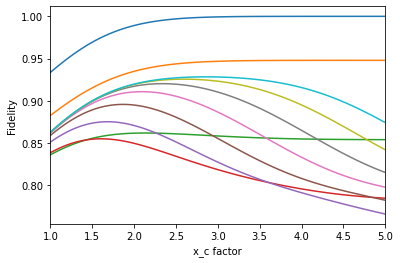

In [8]:
rel = np.zeros(Nx)
for i in range(Nx):
    F0 = F[i,:][0]
    Fmin = np.min(F[i,:])
    Fmax = np.max(F[i,:])
    rel[i] = Fmax/F0
    
    
for i in range(10):
    plt.plot(np.linspace(lim[0],lim[1],N),F[10*i,:])
    
#plt.legend()
plt.xlabel(r'$x_c$ factor')
plt.ylabel('Fidelity')
plt.xlim([1,5])
plt.show()

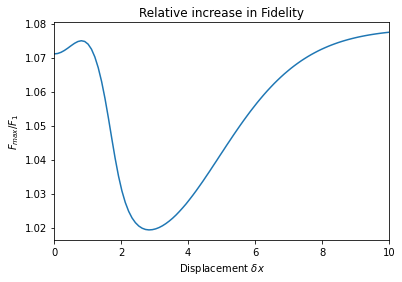

In [11]:
plt.plot(dx,rel)
plt.xlabel(r'Displacement $\delta x$')
plt.title('Max relative increase in Fidelity')
plt.ylabel(r'$F_{max}/F_1$')
plt.xlim([0,10])
plt.show()

In [13]:
Frel = np.linspace(1.003,1.08,10)
xc_opt = np.zeros((Nx,10))
for i, x in enumerate(dx):
    for j, rel in enumerate(Frel):
        xc_opt[i,j] = get_best_xc_factor(x,p,100,rel,lim)



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\olga solodovnikova\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-db174a112090>", line 5, in <module>
    xc_opt[i,j] = get_best_xc_factor(x,p,100,rel,lim)
  File "<ipython-input-5-3c20d5c667bb>", line 42, in get_best_xc_factor
    F = np.sum(sim.get_fidelity())
  File "<ipython-input-3-7151c03d82ff>", line 314, in get_fidelity
    Fij[i,j] = pi*pj[j]*self.fidelity_pure(sigma1,sigma2,r1,r2)
  File "<ipython-input-3-7151c03d82ff>", line 273, in fidelity_pure
    f = 1/np.sqrt(np.linalg.det(S))*np.exp(-1/2*np.transpose(dr).dot(np.linalg.inv(S).dot(dr)))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\olga solodovnikova\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactivesh

TypeError: object of type 'NoneType' has no len()

In [14]:
Frel = 1.007
xc_opt = np.zeros(Nx)

for i, x in enumerate(dx):
     xc_opt[i]= get_best_xc_factor(x,p,100,Frel,lim)
        
print(xc_opt)

[1.12121212 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212
 1.12121212 1.12121212 1.12121212 1.16161616 1.16161616 1.16161616
 1.16161616 1.16161616 1.16161616 1.16161616 1.16161616 1.16161616
 1.16161616 1.16161616 1.16161616 1.16161616 1.2020202  1.2020202
 1.2020202  1.2020202  1.2020202  1.2020202  1.2020202  1.16161616
 1.16161616 1.16161616 1.16161616 1.16161616 1.16161616 1.16161616
 1.16161616 1.16161616 1.16161616 1.16161616 1.16161616 1.16161616
 1.16161616 1.16161616 1.16161616 1.16161616 1.12121212 1.12121212
 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212
 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212
 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212
 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212
 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212
 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212
 1.12121212 1.12121212 1.12121212 1.12121212 1.12121212 1.12121

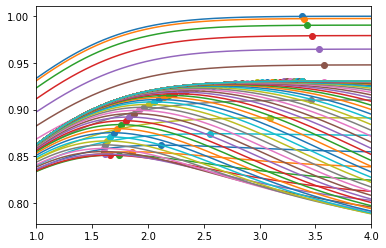

In [372]:
for i in range(100):
    Fplot = F[i,:]
    plt.plot(np.linspace(1,4,200),Fplot)
    Fpoint = Fplot[np.linspace(1,4,200)==xc[i]]
    plt.scatter(xc[i],Fpoint,marker ='o')
#print(Fpoint,xc[10])
#xc[10]
plt.xlim([1,4])
plt.show()

In [374]:
rel = np.zeros(100)
for i in range(100):
    
    F0 = F[i,:][0]
    Fmax = np.max(F[i,:])
    rel[i] = Fmax/F0

#plt.scatter(np.arange(100),rel)
print(np.min(rel))

1.0193149832898496


(-0.0001, 0.0002)

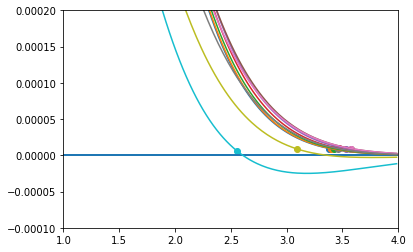

In [365]:
for i in range(10):
    Fplot = np.diff(F[i,:])
    plt.plot(np.linspace(1,4,200)[:-1],Fplot)
    Fpoint = Fplot[np.linspace(1,4,200)[:-1]==xc[i]]
    plt.scatter(xc[i],Fpoint[0],marker ='o')
    plt.hlines(0,0,4)
plt.xlim([1,4])
plt.ylim([-0.0001,0.0002])

In [261]:
xc[xc > 5]

np.arange(100)[xc > 5]

array([33, 47, 52])

In [266]:
xc[47]

7.73869348994975

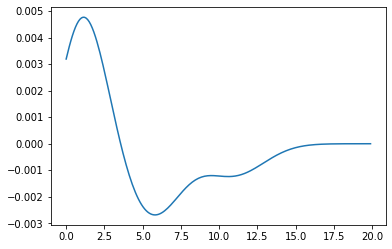

In [267]:
plt.plot(np.linspace(1e-7,20,200)[:-1],np.diff(F[47,:]))

### xc optimisation using pj

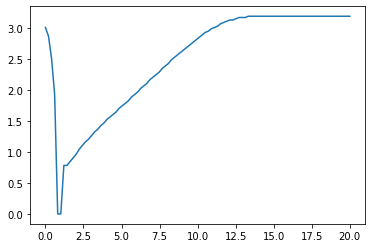

In [85]:
N = 200
Nx = 100
dx = np.linspace(1e-7,20,Nx)
p = 0.1


def get_best_xc(dx,p,N,lim = np.array([1e-7,4])):
#lim = np.array([1,4])
#N = 100
    xc = np.linspace(lim[0],lim[1],N)*np.sqrt(1/2)

    pjavg = np.zeros(N)

    for i in range(N):

        sim = simulation(0,dx,p,xc[i])
        pjmax = sim.get_pjmax()
        pjavg[i]= np.mean(pjmax)

    best = np.min(xc[ np.abs(pjavg - np.max(pjavg)) < 0.001 ])/np.sqrt(1/2)
    
    return best

best = np.zeros(Nx)
for i, x in enumerate(dx):
    best[i] = get_best_xc(x,p,N)

plt.plot(dx,best)
    

In [91]:
print(np.sqrt(2/3),np.sqrt(1/6),np.sqrt(1/2))

0.816496580927726 0.408248290463863 0.7071067811865476


In [89]:
get_best_xc(1.2,0.1,100)

0.7676768484848485

In [57]:
def get_pjmax():
    dic = self.dict_pipj()
    dec = self.dec_dict
    pjmax = np.zeros(8)
    i = 0
    for key in dic.keys():
        pj = dic[key]['pj']
        pat = dec[key]['pattern']
        idx = [i for i, test in enumerate(pjkey) if test == pat][0]
        pjmax[i] = pj[idx]
        i += 1
    return pjmax


[0.46606494 0.75046068 0.67800088 0.75046068 0.75046068 0.67800088
 0.75046068 0.46606494]


In [ ]:
def Wig_coherent(x,xbar):
        
    W = np.sqrt(1/np.pi)*np.exp(-(x-xbar)**2)
    return W
fig = plt.figure(figsize=(0.5*width,4))

X = np.linspace(-3,3,1000)

plt.ylim([-0.05,0.65])
plt.vlines(1,plt.ylim()[0],plt.ylim()[1],'k',linewidth=1)
plt.vlines(-1,plt.ylim()[0],plt.ylim()[1],'k',linewidth=1)
plt.plot(X,Wig_coherent(X,0),label=r'$P_{ki}(m_k)$')
plt.xticks([-1,0,1],[r'$-x_c$',r'$0$',r'$x_c$'])
#plt.legend([r'$P_{ki}(m_k)$'])
plt.xlim([-3,3])
#plt.ylim([np.min(Wig_coherent(X,0)),np.max(Wig_coherent(X,0))])
plt.yticks([0],[r'$0$'])
#plt.ylabel(r'Probability distribution $P_{ki}(m_k)$')
#plt.xlabel(r'Measurement value $m_k$')
plt.figtext(0.25,0.5,r'$-$',fontsize=20)
plt.figtext(0.5,0.5,r'$0$',fontsize=20)
plt.figtext(0.75,0.5,r'$+$',fontsize=20)

#plt.fill_between(X[X>1],Wig_coherent(X[X>1],0),np.repeat(0,len(X[X>1])),label=r'$P_{ki}(+|0)$')

#plt.legend()
#plt.savefig('Ancilla measurement.pdf')
plt.show()

### Ancilla probabilty distribution

TypeError: get_best_xc_factor() missing 1 required positional argument: 'Frel'

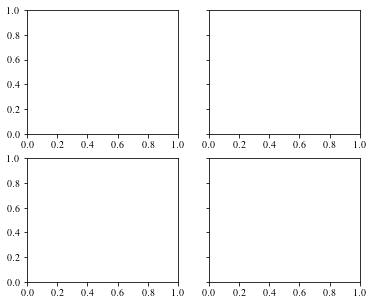

In [4]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(width,5),sharey=True,sharex=False)

r = 0
dx = 5
p = 0.2
xc = 3*np.sqrt(np.exp(-2*r)/2)
xc_best = get_best_xc_factor(dx,p,100)*np.sqrt(1/2)

r1 = 1
xcr = 3*np.sqrt(np.exp(-2*r1)/2)


sim1= simulation(r,dx,p,xc)
dic1 = sim1.dec_dict


sim2 = simulation(r,dx,p,xc_best)
dic2  = sim2.dec_dict


X = np.linspace(-dx,dx,100)

def P_ancilla(x,xbar,r):
        
    P = np.sqrt(1/(np.pi*np.exp(-2*r)))*np.exp(-np.exp(2*r)*(x-xbar)**2)
    return P


def plot_anc(ax,xdec,r,r1,X,key,xc,xcr,xc_best,c):
    
    ax.plot(X,P_ancilla(X,xdec,r),color = c,label = key)
    ax.plot(X,P_ancilla(X,xdec,r1),color = c,alpha = 0.5)
    #label =  r'$r={:.1f}$ dB'.format(r_to_dB(1))
    
    ax.vlines(xc_best,-1,1,'k',linewidth = 1,label = r'$x_{c,best}$')
    ax.vlines(-xc_best,-1,1,'k',linewidth = 1)
    
    ax.vlines(xcr,-1,1,'grey',linewidth=1,linestyle='dashed',label = r'$x_{c,r}$')
    ax.vlines(-xcr,-1,1,'grey',linewidth=1,linestyle='dashed')
    
    ax.vlines(xc,-1,1,'k',linewidth=1,linestyle = 'dashed',label = r'$x_{c,vac}$')
    ax.vlines(-xc,-1,1,'k',linewidth=1,linestyle = 'dashed')
    
    ax.set_ylim([-1e-7,0.7])
    ax.set_xticks([-xc_best,0,xc_best])
    ax.set_xlim([-dx,dx])
    ax.set_xticklabels([r'$-x_{c}$',r'$0$',r'$x_{c}$'])
    
def xdec(dic,key,dx):
    return dic[key]['xdec']*dx

key1 = '(0,0,0)'
key2 = '(dx,0,0)'

key3 = '(0,dx,0)'
key4 = '(0,dx,dx)'

xdec1 = xdec(dic1,key1,dx)
xdec2 = xdec(dic1,key2,dx)
xdec3 = xdec(dic1,key3,dx)
xdec4 = xdec(dic1,key4,dx)

key1 = r'$(0,0,0)$'
key2 = r'$(\delta x,0,0)$'
key3 = r'$(0,\delta x,0)$'
key4 = r'$(0,\delta x,\delta x)$'

plot_anc(ax1,xdec1[1],r,r1,X,key1,xc,xcr,xc_best,'b')
plot_anc(ax2,xdec1[2],r,r1,X,key1,xc,xcr,xc_best,'b')

plot_anc(ax1,xdec2[1],r,r1,X,key2,xc,xcr,xc_best,'r')
plot_anc(ax2,xdec2[2],r,r1,X,key2,xc,xcr,xc_best,'r')

plot_anc(ax3,xdec3[1],r,r1,X,key3,xc,xcr,xc_best,'g')
plot_anc(ax4,xdec3[2],r,r1,X,key3,xc,xcr,xc_best,'g')

plot_anc(ax3,xdec4[1],r,r1,X,key4,xc,xcr,xc_best,'m')
plot_anc(ax4,xdec4[2],r,r1,X,key4,xc,xcr,xc_best,'m')

    
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax3.get_legend_handles_labels()

ax1.legend(handles1[0:2],labels1[0:2])
ax2.legend(handles1[2:5],labels1[2:5])

ax3.legend(handles2[0:2],labels2[0:2])
ax4.legend(handles2[2:5],labels2[2:5])

#ax2.legend(handles1[0:7],labels1[0:7],bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
#ax4.legend(handles2[0:7],labels2[0:7],bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)

#handlesnew = list((handles1[0],handles1[1],handles1[2],handles2[0],handles2[2],handles1[4],handles1[5],handles1[6]))
#labelsnew = list((labels1[0],labels[1],labels1[2],labels2[0],labels2[2],labels1[4],labels1[5],labels1[6]))


#ax2.legend(handlesnew,labelsnew,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#ax2.legend(handles[3:6],labels[3:6])

#handles, labels = ax3.get_legend_handles_labels()
#ax3.legend(handles[0:2],labels[0:2])
#ax4.legend(handles[3:6],labels[3:6])
    

#plot_ancilla(ax1,ax2,dic2,'(0,0,0)',xc_best,dx,r,X)
#plot_ancilla(ax1,ax2,dic2,'(dx,dx,0)',xc_best,dx,r,X)

#ax1.vlines(xc,-1,1,'grey',linewidth=1)
#ax1.vlines(-xc,-1,1,'grey',linewidth=1)

#ax2.vlines(xc,-1,1,'grey',linewidth=1)
#ax2.vlines(-xc,-1,1,'grey',linewidth=1)

    
#ax1.set_ylim([-1e-7,0.8])
#ax2.set_xlim([-10,10])


ax1.set_title('Ancilla 1')
ax2.set_title('Ancilla 2')
ax1.set_ylabel('Probability density')
ax3.set_ylabel('Probability density')
#ax1.legend()
#ax3.legend()
#plt.savefig('Figures/Ancilla_ProbDistribution.pdf')
plt.show()

In [167]:
r_to_dB(1)

8.685889638065037

In [145]:
list((X[0:2],X[2],X[5:7]))

[[<matplotlib.lines.Line2D at 0x1adb7067ca0>,

In [ ]:
r = 1


def P_minus(xc,xdec,r):
    return 0.5*(1-special.erf(np.exp(r)*(xc+xdec)))

def P_plus(xc,xdec,r):
    return 0.5*(1-special.erf(np.exp(r)*(xc-xdec)))

def P_zero(xc,xdec,r):
    return 0.5*(special.erf(np.exp(r)*(xc-xdec))+special.erf(np.exp(r)*(xc+xdec)))

xdec = 1/np.sqrt(6)
x = np.linspace(0,3,100)
xc = 3*np.exp(-r)/np.sqrt(2)
print(xc)
print(1/np.sqrt(6))
plt.plot(x,P_minus(x,xdec,r),label = r'$P(-)$')
plt.plot(x,P_plus(x,xdec,r),label = r'$P(+)$')
plt.plot(x,P_zero(x,xdec,r),label = r'$P(0)$')
plt.plot(xc,P_minus(xc,xdec,r),'o',markersize = 10)
plt.legend()
plt.xlabel(r'$x_c$')
plt.ylabel(r'Probability')
plt.show()

In [ ]:
dx = 1
r = 3
xc = 1*np.sqrt(np.exp(-2*r)/2)

for key in dic:
    
    xdec = dic[key]['xdec']*dx
    
    bound1 = get_bounds_dict(r,xc,xdec[1])
    bound2 = get_bounds_dict(r,xc,xdec[2])
    pat = ['00','--','+0','-+','+-','-0','++','00']
    pj = np.zeros(8)
    for i, p in enumerate(pat):
      
        P1 = bound1[p[0]]['P']
        P2 = bound2[p[1]]['P']
        pj[i] = P1*P2
    
    dic[key]['pj'] = pj
   


In [ ]:
def Wigafterij(x1,p1,xbar,pbar,r,s2,s3,xdec1,xdec2,xdec3,pi,pj):
    
    prefactor = pi*pj*2/np.pi*1/(np.pi*np.exp(-2*r))*np.sqrt(np.pi/(np.exp(2*r)/s2**2)+1)1/(s2*s3)*np.sqrt(np.pi/(1+np.exp(2*r)/s2**2+np.exp(2*r)/s3**3))
    exponential = np.exp(-(p1-pbar)**2)*np.exp(-(x1-(xdec1+s2*xdec2+s3*xdec3))**2/(1+s2**2/np.exp(2*r)+s3**2/np.exp(2*r)))
    return prefactor*exponenital

In [ ]:
fig = plt.figure(figsize =(width,height))

X = np.linspace(-2,2,1000)
r = np.array([0,1,3])
for i in r:
    plt.plot(X,special.erf(np.exp(i)*X),label = r'$r = {}$'.format(i))

plt.xlabel(r'$x$')
plt.ylabel(r'erf$(e^r x)$')
plt.legend()
plt.xlim([-2,2])
plt.xticks([-2,-1,0,1,2])
plt.grid('on')
plt.savefig('erf.pdf')
plt.show()



In [ ]:
15.1694/4

In [ ]:
15/2

In [ ]:
15/3

In [ ]:
10**(-3/10)

In [ ]:
-10*np.log10(np.exp(-2*1))